In [1]:
import os,re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.sparse as sp
from tools.model_func import get_input
import seaborn as sns
from sklearn.metrics import f1_score,precision_score
import warnings

W0828 18:57:56.131969 140000703145792 deprecation_wrapper.py:119] From /home/angela/xmtc/tools/model_func.py:21: The name tf.keras.layers.CuDNNLSTM is deprecated. Please use tf.compat.v1.keras.layers.CuDNNLSTM instead.



# metric helpers

In [2]:
def get_sparse_k(y_true,y_pred,k,include_rank=False):
    m,n = y_true.shape
    rows = np.repeat(np.arange(m),k)
    cols = y_pred[:,:k].flatten()
    if include_rank:
        data = np.tile(np.arange(k)+1,m)
    else:
        data = np.ones_like(rows)
    return sp.csr_matrix((data,(rows,cols)),shape=(m,n))
def get_pAtk(y_true,y_pred,k):
    pred = get_sparse_k(y_true,y_pred,k)
    patk = (y_true.multiply(pred).sum(axis=1)).A1
    return patk
def get_nDCGAtk(y_true,y_pred,k):
    pred = get_sparse_k(y_true,y_pred,k,include_rank=True)
    pred.data = 1/np.log(pred.data+1)
    dcg = y_true.multiply(pred).sum(axis=1).A1
    num_labs = y_true[0,:].sum() # small cheat coz we know |y|_0 is constant
    norm_const = (1/np.log(np.arange(min(k,num_labs))+2)).sum()
    ndcg = dcg/norm_const
    return ndcg
def get_multilabel_pAtk(y_true,y_pred,k):
    pred = get_sparse_k(y_true,y_pred,k)
    patk = (y_true.multiply(pred).sum(axis=1)/k).A1
    return patk
def get_micro_categorical_accuracy(y_true,y_pred,k):
    pred = get_sparse_k(y_true,y_pred,k)
    return y_true.multiply(pred).sum(axis=1).A1
def get_macro_precision(y_true,y_pred,k):
    pred = get_sparse_k(y_true,y_pred,k)
    return precision_score(trues,pred,average=None)
def get_macro_F1(y_true,y_pred,k):
    pred = get_sparse_k(y_true,y_pred,k)
    return f1_score(trues,pred,average=None)

# input helper

In [3]:
def get_args(in_dir):
    dirs = sorted([os.path.join(in_dir,d) for d in os.listdir(in_dir)])
    out_d = defaultdict(list)
    for d in dirs:
        log_dir = os.path.join(d,'train.log')
        args_dir = os.path.join(d,'args.csv')
        if not os.path.exists(log_dir) or not os.path.exists(args_dir):
            continue
        df = pd.read_csv(log_dir)
        arg = pd.read_csv(args_dir)
        mode = arg.loc[0,'mode']
        arg['dir'] = d
        df['dir'] = d
        out_d[mode].append(df)   
        out_d['args'].append(arg)
    args = pd.concat(out_d['args'], ignore_index = True, sort = False)
    return args

In [4]:
def get_categorical_preds(model_dir,topk=5):
    if 'FastText' in model_dir:
        pred_dirs = sorted([os.path.join(model_dir,d) for d in os.listdir(model_dir)])[1:]
    else:
        pred_dirs = sorted([os.path.join(model_dir,d) for d in os.listdir(model_dir) if d.startswith('pred_outputs')])
    preds = [np.loadtxt(pred_dir,dtype=int,usecols=np.arange(topk)).reshape([-1,topk]) for pred_dir in pred_dirs]
    return preds

In [5]:
def get_preds(model_dir,y_tests,per_hierarchy=False):
    cnts = [y_tests[i].shape[1] for i in range(len(y_tests))]
    offsets = [0] + [cnts[i]+sum(cnts[:i]) for i in range(len(cnts))]
    if not per_hierarchy:
        if 'FastText' in model_dir:
            preds = np.loadtxt(os.path.join(model_dir,'pred_outputs.txt'),dtype=int)


        else:
            long_dir = os.path.join(model_dir,'combined_pred_outputs.txt')
            if os.path.exists(long_dir):
                preds = np.loadtxt(long_dir)
            else:
                pred_dirs = sorted([os.path.join(model_dir,d) for d in os.listdir(model_dir) if d.startswith('pred_outputs')])
                preds = [np.loadtxt(pred_dir,dtype=int) for pred_dir in pred_dirs]
                logi_dirs = sorted([os.path.join(model_dir,d) for d in os.listdir(model_dir) if d.startswith('pred_logits')])
                logits = [np.loadtxt(dir) for dir in logi_dirs]

                for i in range(0,len(preds)):
                    preds[i]=preds[i]+offsets[i]
                preds = np.concatenate(preds,axis=1)
                # combined top k prediciton
                ll = np.concatenate(logits,axis=1)
                inds = np.argsort(ll,axis=1)[:,:-11:-1]
                preds = np.take_along_axis(preds, inds, axis=1)
                np.savetxt(long_dir,preds,fmt='%d')
                print('SAVE COMBINED PREDICTIONS:\n{}'.format(long_dir))

    else:
        if 'FastText' in model_dir:
            pred_dirs = sorted([os.path.join(model_dir,d) for d in os.listdir(model_dir)])[1:]
            preds = [np.loadtxt(pred_dir,dtype=int,usecols=0)+offsets[i] for i,pred_dir in enumerate(pred_dirs)]
        else:
            pred_dirs = sorted([os.path.join(model_dir,d) for d in os.listdir(model_dir) if d.startswith('pred_outputs')])
            preds = [np.loadtxt(pred_dir,dtype=int,usecols=0)+offsets[i] for i,pred_dir in enumerate(pred_dirs)]
        preds = np.vstack(preds).T
    return preds
        

# get metrics at different levels

In [6]:
def get_categorical_scores(d,y_tests,metrics,ks):
    print(d)
    preds = get_categorical_preds(d,max(ks))
    dfs = []
    s = np.arange(preds[0].shape[0])
    for H in range(len(preds)):
        df = pd.DataFrame(index=s)
        df['sample_ind']=s
        df['H']='H{}'.format(H)
        for key,func in metrics.items():
            for k in ks:
                metric = key.format(k)
                df[metric] = func(y_tests[H],preds[H],k) # func returns metric per sample
        dfs.append(df)
    df = pd.concat(dfs,sort=False)
    df['dir'] = d
    df['model'] = d.split('_')[-1]
    return df

In [7]:
def get_micro_scores(d,trues,y_tests,metrics,ks,per_hierarchy):
    print(d)
    preds = get_preds(d,y_tests,per_hierarchy=per_hierarchy)
    dic = {}
    dic['dir'] = d
    dic['model'] = d.split('_')[-1]
    for key,func in metrics.items():
        for k in ks:
            metric = key.format(k)
            dic[metric] = func(trues,preds,k).mean()
    return pd.DataFrame.from_dict([dic])

In [8]:
# get multi-label metrics
def get_multi_label_metrics(d,trues,y_tests,metrics,ks=[1,3,5]):
    print(d)
    preds = get_preds(d,y_tests,per_hierarchy=False)
    outs = []
    for key,func in metrics.items():
        scores = []
        for i in ks:
            score = func(trues,preds,i).mean()
            scores.append(score)
            print('{}{}:{:.2f}'.format(key,i,score*100),end=' ')
        print()
        outs.append([scores])
    return outs

In [9]:
# get_per_H_metrics
def get_per_H_metrics(d,y_tests,metrics,ks=[1,3,5]):
    print(d)
    preds = get_preds(d,per_hierarchy=True)
    outs = []
    for key,func in metrics.items():
        scoress = []
        for H in range(len(preds)):
            scores = []
            print('H{}:  '.format(H),end='')
            for i in ks:
                score = func(y_tests[H],preds[H],i).mean()
                scores.append(score)
                print('{}{}:{:.2f}'.format(key,i,score*100),end=' ')
            print()
            scoress.append(scores)
        outs.append(scoress)
    return outs

In [10]:
def get_macro_scores(d,trues,y_tests,metrics,groups,ks,per_hierarchy):
    print(d)
    preds = get_preds(d,y_tests,per_hierarchy=per_hierarchy)
    rows = []
    for key,func in metrics.items():
        for k in ks:
            ss = func(trues,preds,k)
            for g,group in enumerate(groups):
                dic = {}
                dic['dir'] = d
                dic['model'] = d.split('_')[-1]
                dic['group'] = 'G{}'.format(g)
                metric = key.format(k)
                for ind in group:
                    dic[metric] = ss[ind]
                    dic['lab_ind']=ind
                    rows.append({key:val for key,val in dic.items()})
    df = pd.DataFrame.from_dict(rows)
    df = df.groupby(['dir','lab_ind']).max().reset_index()
    return df

In [11]:
# get groups
def get_groups(y_trains,num_groups = 3):
    # get train label frequencey
    train_cnts = np.hstack([y.sum(axis=0).A1 for y in y_trains])
    lab_to_cnts = {i:cnt for i,cnt in enumerate(train_cnts)}
    sorted_labs = sorted(lab_to_cnts.keys(),key=lambda x:lab_to_cnts[x])
    # get groups by count
    group_cnt = sum([cnt for cnt in lab_to_cnts.values()])/num_groups
    groups = []
    accumulated_cnts = 0
    group = []
    for lab in sorted_labs:
        accumulated_cnts+=lab_to_cnts[lab]
        if accumulated_cnts>group_cnt and len(groups)<num_groups:
            groups.append(group)
            group = [lab]
            accumulated_cnts = 0
        else:
            group.append(lab)
    groups.append(group)
    # print things
    cut_off = [0]+[lab_to_cnts[g[-1]] for g in groups]
    t_bound = ['${} < t < {}$'.format(cut_off[i],cut_off[i+1])for i in range(len(groups))]
    lab_per_group = [len(g) for g in groups]
    perc_lab_per_group = [g/sum(lab_per_group)*100 for g in lab_per_group]
    df = pd.DataFrame()
    df['group'] = ['G{}'.format(g) for g in range(len(groups))]
    df['num_train'] = [sum([lab_to_cnts[lab] for lab in group])for group in groups]
    df['perc_train'] = df['num_train']/df['num_train'].sum()*100
    
    df['num_train_cut_off'] = cut_off[1:]
    df['t_bound'] = t_bound
    df['num_labels'] = lab_per_group
    df['perc_labels'] = df['num_labels']/df['num_labels'].sum()*100
    return groups,df

# get group table for latex

In [ ]:
dfs = []
names = ['SIC Code','AmazonCat-13k']
for i,DATA in enumerate(['sic_hierarchy','amazon_hierarchy_2']):
    IN_DIR = 'data/{}'.format(DATA)
    _,y_trains,_,_ = get_input(mode='cat', in_dir = IN_DIR, sparse = True, get_output= [0,1,0,0])
    _,df = get_groups(y_trains,num_groups = 3)
    df['data'] = names[i]
    dfs.append(df)
df = pd.concat(dfs)
df = df.set_index(['data','group'])
df.index.names=[None,None]

In [ ]:
cols = ['num_train','num_labels','perc_labels','t_bound']
header = ['Train Samples','No. Labels','% Labels','Train Samples per label (t)']
ll = df[cols].to_latex(header = header,index=True,float_format='%.2f',multirow=True)
# ll = ll.replace('  ',' ')
ll = re.sub(' {2,}', '',ll)
ll = ll.replace('\$','$')
# ll = ll.replace('<','$<$')
print(ll)

In [ ]:
# random fast cheat
# get args
args = get_args('outputs')

In [ ]:
df = args
df = df[df['mode']=='cat']
df = df[df['loss']=='categorical']
df = df[df['model'].isin(models)]
df

In [ ]:
for i,data in enumerate(['sic_hierarchy','amazon_hierarchy_2']):
    print(data)
    in_dir = os.path.join('data',data)
    for d in df[df['input']==in_dir].dir.to_list():
        print(d)
        _,_,_,y_tests = get_input(mode='cat', in_dir = in_dir, sparse = True, get_output= [0,1,0,1])
        trues = sp.hstack(y_tests).tocsr()
        preds = get_preds(d,y_tests,per_hierarchy=False)
        for k in [1,3,4]:
            score = get_multilabel_pAtk(trues,preds,k).mean()*100
            print('P@{}  :{:.2f}'.format(k,score))

# MICRO

In [13]:
# get args
args = get_args('outputs')

## binary

In [73]:
# simple table for macro scores
metrics = {
    'nDCG@{}':get_nDCGAtk,
    'p@{}':get_multilabel_pAtk,
}
kss = [[1,3,5,4],[1,3,5]]
dfs = []
for LOSS in ['categorical','binary']:
    for i,DATA in enumerate(['sic_hierarchy','amazon_hierarchy_2']):
        in_dir = 'data/{}'.format(DATA)
        df = args
        df = df[df['mode']=='cat']
        df = df[df['input']==in_dir]
        df = df[df['loss']==LOSS]
        dirs = sorted(df.dir.to_list())
        dirs = ['outputs/{}_c_FastText'.format(DATA)] + dirs
        _,y_trains,_,y_tests = get_input(mode='cat', in_dir = in_dir, sparse = True, get_output= [0,1,0,1])
        trues = sp.hstack(y_tests).tocsr()
        for ph in [True,False]:
            if ph:
                ks = [k for k in kss[i] if k<5]
            else:
                ks = kss[i]
            for d in dirs:
                df = get_micro_scores(d,trues,y_tests,metrics,ks=ks,per_hierarchy=ph)
                df['loss']=LOSS
                df['input']=in_dir
                df['per_hierarchy']=ph
                dfs.append(df)

outputs/sic_hierarchy_c_FastText
outputs/190726_210000_xmlcnn
outputs/190726_210738_attentionxml
outputs/190726_224702_attention
outputs/190810_151748_bert
outputs/190816_003525_bert
outputs/sic_hierarchy_c_FastText
outputs/190726_210000_xmlcnn
outputs/190726_210738_attentionxml
outputs/190726_224702_attention
outputs/190810_151748_bert
outputs/190816_003525_bert
outputs/amazon_hierarchy_2_c_FastText
outputs/190823_172116_xmlcnn
outputs/190823_174301_attentionxml
outputs/190824_133144_attention
outputs/190824_215412_bert
outputs/amazon_hierarchy_2_c_FastText
outputs/190823_172116_xmlcnn
outputs/190823_174301_attentionxml
outputs/190824_133144_attention
outputs/190824_215412_bert
outputs/sic_hierarchy_c_FastText
outputs/190726_183629_xmlcnn
outputs/190726_184436_attentionxml
outputs/190726_202322_attention
outputs/190816_054515_bert
outputs/sic_hierarchy_c_FastText
outputs/190726_183629_xmlcnn
outputs/190726_184436_attentionxml
outputs/190726_202322_attention
outputs/190816_054515_bert


In [82]:
df =pd.concat(dfs,sort=False)
# df.to_pickle('outputs/dfs/combined3.pkl')

### print tabel

In [83]:
df = pd.read_pickle('outputs/dfs/combined3.pkl')
models=['FastText','xmlcnn','attentionxml','attention']
df = df[df['per_hierarchy']==False]
df = df.drop(columns=['per_hierarchy'])
df = df[df['model'].isin(models)]
df = df.set_index(['dir','model','loss','input']).transpose()
df = df.unstack().reset_index().drop(columns=['dir']).set_index(['loss','input','level_4','model']).unstack([-1])
df = df[0].reset_index().rename(columns={'level_4':'metrics'})

In [84]:
df1 = df
df1['input'] = df1['input'].apply(lambda x:x.split('/')[-1].split('_')[0])
df1 = df.set_index(['loss','input','metrics'])
df1 = df1[models]

In [85]:
df2 = df1.loc[('categorical','amazon')]*100
df2

model,FastText,xmlcnn,attentionxml,attention
metrics,,,,
nDCG@1,90.534235,88.890198,86.899939,80.378590
nDCG@3,71.024217,61.091158,73.791844,64.657087
nDCG@4,NaN,NaN,NaN,NaN
nDCG@5,76.284879,64.763883,79.608656,71.424084
p@1,90.534235,88.890198,86.899939,80.378590
p@3,65.238590,53.056835,70.037541,60.120221
p@4,NaN,NaN,NaN,NaN
p@5,44.571756,35.620509,48.018499,43.046335


In [69]:
print(df2.to_latex(float_format='%.2f').replace(' ',''))

\begin{tabular}{lrrrr}
\toprule
model&FastText&xmlcnn&attentionxml&attention\\
metrics&&&&\\
\midrule
nDCG@1&90.53&90.16&91.80&85.98\\
nDCG@3&71.02&68.85&75.51&67.85\\
nDCG@4&74.30&72.24&78.96&71.49\\
nDCG@5&76.28&74.38&81.07&73.78\\
p@1&90.53&90.16&91.80&85.98\\
p@3&65.24&62.58&70.77&62.63\\
p@4&52.98&51.14&57.34&51.47\\
p@5&44.57&43.27&48.20&43.71\\
\bottomrule
\end{tabular}



## categorical

In [ ]:
# categorical
dfs = []
ks = [1,5]
metrics = {
    'top_{}_acc':get_micro_categorical_accuracy
}
for loss in ['categorical','binary']:
    for i,data in enumerate(['sic_hierarchy','amazon_hierarchy_2']):
        print(data,loss)
        in_dir = 'data/{}'.format(data)
        df = args
        df = df[df['mode']=='cat']
        df = df[df['input']==in_dir]
        df = df[df['loss']==loss]
        dirs = sorted(df.dir.to_list())
        dirs = ['outputs/{}_c_FastText'.format(data)] + dirs
        _,y_trains,_,y_tests = get_input(mode='cat', in_dir = in_dir, sparse = True, get_output= [0,1,0,1])
        for d in dirs:
            df = get_categorical_scores(d,y_tests,metrics,ks)
            df['loss']=loss
            df['input']=in_dir
            dfs.append(df)  


In [ ]:
df = pd.concat(dfs)
# df.to_pickle('outputs/dfs/combined1.pkl')

### change in categorical accuracy by using new loss

In [ ]:
df = pd.read_pickle('outputs/dfs/combined1.pkl')
models = ['FastText','xmlcnn','attentionxml','bert']
df1 = df
df1 = df[df['model'].isin(models)]
df1 = df1.groupby(['loss','input','model','H']).mean().unstack([0,-1]).stack().transpose().swaplevel(0,1).transpose()
(df1['categorical']-df1['binary']).unstack([-2])

### P@n

In [ ]:
df = pd.read_pickle('outputs/dfs/combined1.pkl')

In [ ]:
models = ['xmlcnn','attentionxml','attention']
# function
df1 = df
df1 = df1[df1.model.isin(models)]
# P@|y|
df2 = df1.groupby(['loss','input','model'])['top_1_acc'].mean().unstack([-1])[models]
df2

In [ ]:
# P@1
df2 = df1.groupby(['loss','input','model','sample_ind'])['top_1_acc'].max().reset_index(['sample_ind'])
df2 = df2.groupby(['loss','input','model'])['top_1_acc'].mean().unstack([-1])[models]
df2

In [ ]:
print((df2*100).to_latex(float_format='%.2f').replace(' ',''))

### PLOT : Categorical

In [ ]:
df = pd.read_pickle('outputs/dfs/combined1.pkl')
metric_dict = {
    'top_1_acc':'Categorical Accuracy',
    'top_5_acc':'Top-5 Accuracy',
}
data_dict = {
    'data/sic_hierarchy':'SIC Code',
    'data/amazon_hierarchy_2':'AmazonCat-13k',
}

In [ ]:
# compare model performance in terms of categorical accuracy (models trained with categorical loss)
# PARAMS
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['FastText','xmlcnn','attentionxml','bert']
metrics = ['top_1_acc','top_5_acc']

# function
df1 = df
df1 = df1[df1.model.isin(models)]
df1 = df1[df1['loss']=='categorical']
df1 = df1.groupby(['loss','input','model','H']).mean().reset_index(['model','H'])
# bar chart of mean
for data in datas:
    df2 = df1.loc[('categorical',data),:]
    for metric in metrics:
        H = sorted(df2.H.unique())
        # plot
        fig,ax = plt.subplots()
        bar = sns.barplot(
            x = 'H',
            y=metric,
            hue='model',
            data = df2,
            ax = ax, 
            palette="Set3",
            order=H,
            hue_order = models
           )
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=len(models), mode="expand", borderaxespad=0.)
        ax.set_ylabel(metric_dict[metric])
        ax.set_xlabel('{} hierarchical level'.format(data_dict[data]))
        ax.set_ylim(0,1)
        plt.show()


In [ ]:
# compare model performance of different losses in terms of categorical accuracy 
# PARAMS
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['xmlcnn','attentionxml','attention']
metrics = ['top_1_acc','top_5_acc']

# function
df1 = df
df1 = df1[df1.model.isin(models)]
df1 = df1.groupby(['loss','input','model','H']).mean()
df1 = df1.loc['categorical',:] - df1.loc['binary',:]
df1 = df1.reset_index(['model','H'])
# bar chart of mean
for data in datas:
    df2 = df1.loc[data,:]
    for metric in metrics:
        H = sorted(df2.H.unique())
        # plot
        fig,ax = plt.subplots()
        bar = sns.barplot(
            x = 'H',
            y=metric,
            hue='model',
            data = df2,
            ax = ax, 
            palette=sns.color_palette("Set3")[1:],
            order=H,
            hue_order = models
           )
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=len(models), mode="expand", borderaxespad=0.)
        ax.set_ylabel(metric_dict[metric])
        ax.set_xlabel('{} hierarchical level'.format(data_dict[data]))
        ax.axhline(y=0, color='k')
        plt.show()


# MACRO

In [ ]:
# get args
args = get_args('outputs')

In [ ]:
warnings.filterwarnings('ignore')

dfs = []
kss=[[4],[3]]
metrics = {
    'precision':get_macro_precision,
    'F1':get_macro_F1
}
for LOSS in ['categorical','binary']:
    for i,DATA in enumerate(['sic_hierarchy','amazon_hierarchy_2']):
        ks = kss[i]
        in_dir = 'data/{}'.format(DATA)
        df = args
        df = df[df['mode']=='cat']
        df = df[df['input']==in_dir]
        df = df[df['loss']==LOSS]
        dirs = sorted(df.dir.to_list())
        dirs = ['outputs/{}_c_FastText'.format(DATA)] + dirs
        _,y_trains,_,y_tests = get_input(mode='cat', in_dir = in_dir, sparse = True, get_output= [0,1,0,1])
        trues = sp.hstack(y_tests).tocsr()
        groups,_ = get_groups(y_trains,num_groups = 3)
        for ph in [True,False]:
            for d in dirs:
                df = get_macro_scores(d,trues,y_tests,metrics,groups,ks=ks,per_hierarchy=ph)
                df['loss']=LOSS
                df['input']=in_dir
                df['per_hierarchy']=ph
                dfs.append(df)

In [ ]:
df = pd.concat(dfs,sort=False)
df.head()

In [ ]:
# df.to_pickle('outputs/dfs/combined0.pkl')

# macro average scores

In [98]:
df = pd.read_pickle('outputs/dfs/combined0.pkl')
models = ['FastText','xmlcnn','attentionxml','attention']
df1 = df
df1 = df[df['model'].isin(models)]
df1 = df1.drop(columns=['lab_ind'])
df1 = df1.groupby(['loss','input','per_hierarchy','model']).mean().unstack([-1])
df1

F1            \
model                                              FastText attention   
loss        input                   per_hierarchy                       
binary      data/amazon_hierarchy_2 False          0.105603  0.199054   
                                    True           0.113307  0.208418   
            data/sic_hierarchy      False          0.218698  0.205266   
                                    True           0.228434  0.217449   
categorical data/amazon_hierarchy_2 False          0.105603  0.242025   
                                    True           0.113307  0.245655   
            data/sic_hierarchy      False          0.218698  0.223421   
                                    True           0.228434  0.224281   

                                                                          \
model                                             attentionxml    xmlcnn   
loss        input                   per_hierarchy                          
binary      data/amazon_hierarchy_2 False             0.338884  0.149198   
                                    True              0.347706  0.160480   
            data/sic_hierarchy      False             0.295537  0.187995   
                                    True              0.305552  0.200517   
categorical data/amazon_hierarchy_2 False             0.355904  0.054218   
                                    True              0.371146  0.226513   
            data/sic_hierarchy      False             0.310089  0.119916   
                                    True              0.309006  0.243726   

                                                  precision            \
model                                              FastText attention   
loss        input                   per_hierarchy                       
binary      data/amazon_hierarchy_2 False          0.155045  0.256667   
                                    True           0.150116  0.252176   
            data/sic_hierarchy      False          0.305074  0.264263   
                                    True           0.297545  0.259092   
categorical data/amazon_hierarchy_2 False          0.155045  0.264016   
                                    True           0.150116  0.293512   
            data/sic_hierarchy      False          0.305074  0.266921   
                                    True           0.297545  0.284758   

                                                                          
model                                             attentionxml    xmlcnn  
loss        input                   per_hierarchy                         
binary      data/amazon_hierarchy_2 False             0.413679  0.244085  
                                    True              0.407396  0.240318  
            data/sic_hierarchy      False             0.352676  0.283564  
                                    True              0.337747  0.278797  
categorical data/amazon_hierarchy_2 False             0.409222  0.068952  
                                    True              0.426188  0.297022  
            data/sic_hierarchy      False             0.344807  0.247666  
                                    True              0.346938  0.317645

In [108]:
df2 = (df1.loc['categorical',:,True]['F1']*100)[models]
df2

model                                               FastText     xmlcnn  \
loss        input                   per_hierarchy                         
categorical data/amazon_hierarchy_2 True           11.330690  22.651348   
            data/sic_hierarchy      True           22.843423  24.372581   

model                                              attentionxml  attention  
loss        input                   per_hierarchy                           
categorical data/amazon_hierarchy_2 True              37.114609  24.565519  
            data/sic_hierarchy      True              30.900599  22.428141

In [109]:
print(df2.to_latex(float_format='%.2f').replace(' ',''))

\begin{tabular}{lllrrrr}
\toprule
&&model&FastText&xmlcnn&attentionxml&attention\\
loss&input&per\_hierarchy&&&&\\
\midrule
categorical&data/amazon\_hierarchy\_2&True&11.33&22.65&37.11&24.57\\
&data/sic\_hierarchy&True&22.84&24.37&30.90&22.43\\
\bottomrule
\end{tabular}



# Baseline: Get pretty graphs

In [86]:
df = pd.read_pickle('outputs/dfs/combined0.pkl')
metric_dict = {
    'precision':'Precision',
    'F1':'F1 score',
}
data_dict = {
    'data/sic_hierarchy':'SIC Code',
    'data/amazon_hierarchy_2':'AmazonCat-13k',
}

### PLOT : Baseline

In [ ]:
# PARAMS
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['FastText','xmlcnn','attentionxml','attention']
metrics = ['precision','F1']

# function
df1 = df
df1 = df1[df1.loss=='binary']
df1 = df1[df1.model.isin(models)]
df1 = df1[df1.per_hierarchy == False]
# bar chart of mean
for data in datas:
    df2 = df1[df1.input==data]
    for metric in metrics:
        # y tick counts
        cnts = (df2.group.value_counts()/df2.group.value_counts().sum()*100).to_dict()
        groups = sorted(cnts.keys())
        # plot
        fig,ax = plt.subplots()
        bar = sns.barplot(
            x = 'group',
            y=metric,
            hue='model',
            data = df2,
            ax = ax, 
            palette="Set3",
            order=groups,
            hue_order = models
           )
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=len(models), mode="expand", borderaxespad=0.)
        ax.set_ylabel(metric_dict[metric])
        ax.set_xlabel('{} label groups (% labels in group)'.format(data_dict[data]))
        ax.set_xticklabels(['{} ({:.2f}%)'.format(key,cnts[key]) for key in groups])
        ax.set_ylim(0,1)
        plt.show()

### TABLE : Baseline

In [ ]:
# TABLE
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['FastText','xmlcnn','attentionxml','attention']
metrics = ['precision','F1']
for data in datas:
    print(data)
    df2 = df1[df1.input==data]
    srs = (df2.groupby('model')[metrics].mean()*100).to_dict()
    for metric in metrics:
        print('{:10}'.format(metric),end=':')
        print('&'.join(['{:.2f}'.format(srs[metric][key]) for key in models]))

### PLOT : Categorical

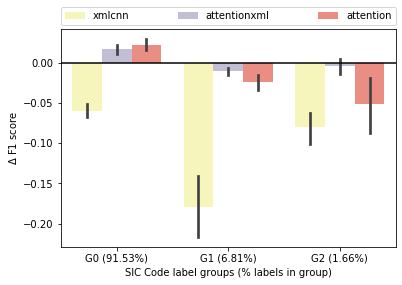

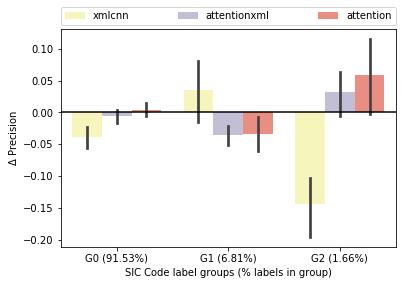

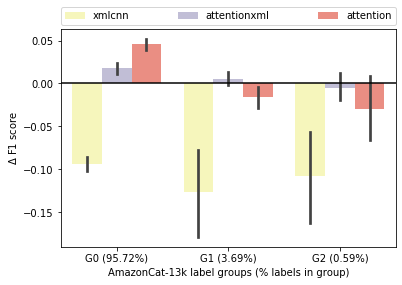

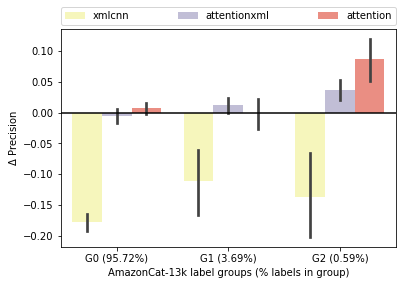

In [87]:
# change in model performance with changed loss (both per hierarchy == False)
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['xmlcnn','attentionxml','attention']
metrics = ['F1','precision']

# function
df1 = df
df1 = df1[df1.model.isin(models)]
df1 = df1[df1.per_hierarchy == False].drop(columns=['per_hierarchy'])
df1 = df1.set_index(['loss']+[col for col in df1.columns if col not in metrics + ['loss']]).reset_index(['dir'])
df1 = df1.drop(columns=['dir'])
# calculation
df1 = (df1.loc['categorical',:]-df1.loc['binary',:]) # change in score
df1 = df1.reset_index(['group','model','lab_ind'])
# bar chart of mean
for data in datas:
    df2 = df1.loc[data,:]
    for metric in metrics:
        # y tick counts
        cnts = (df2.group.value_counts()/df2.group.value_counts().sum()*100).to_dict()
        groups = sorted(cnts.keys())
        # plot
        fig,ax = plt.subplots()
        bar = sns.barplot(
            x = 'group',
            y=metric,
            hue='model',
            data = df2,
            ax = ax, 
            palette=sns.color_palette("Set3")[1:],
            order=groups,
            hue_order = models
           )
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=len(models), mode="expand", borderaxespad=0.)
        ax.set_ylabel('$\Delta$ {}'.format(metric_dict[metric]))
        ax.set_xlabel('{} label groups (% labels in group)'.format(data_dict[data]))
        ax.set_xticklabels(['{} ({:.2f}%)'.format(key,cnts[key]) for key in groups])
        ax.axhline(y=0, color='k')
#         ax.set_ylim(-0.025,0.08)
        plt.show()

In [ ]:
# change in model performance with changed loss (both per hierarchy == True)
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['xmlcnn','attentionxml','attention']
metrics = ['F1','precision']

# function
df1 = df
df1 = df1[df1.model.isin(models)]
df1 = df1[df1.per_hierarchy == True].drop(columns=['per_hierarchy'])
df1 = df1.set_index(['loss']+[col for col in df1.columns if col not in metrics + ['loss']]).reset_index(['dir'])
df1 = df1.drop(columns=['dir'])
# calculation
df1 = (df1.loc['categorical',:]-df1.loc['binary',:]) # change in score
df1 = df1.reset_index(['group','model','lab_ind'])
# bar chart of mean
for data in datas:
    df2 = df1.loc[data,:]
    for metric in metrics:
        # y tick counts
        cnts = (df2.group.value_counts()/df2.group.value_counts().sum()*100).to_dict()
        groups = sorted(cnts.keys())
        # plot
        fig,ax = plt.subplots()
        bar = sns.barplot(
            x = 'group',
            y=metric,
            hue='model',
            data = df2,
            ax = ax, 
            palette=sns.color_palette("Set3")[1:],
            order=groups,
            hue_order = models
           )
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=len(models), mode="expand", borderaxespad=0.)
        ax.set_ylabel('$\Delta$ {}'.format(metric_dict[metric]))
        ax.set_xlabel('{} label groups (% labels in group)'.format(data_dict[data]))
        ax.set_xticklabels(['{} ({:.2f}%)'.format(key,cnts[key]) for key in groups])
        ax.axhline(y=0, color='k')
        ax.set_ylim(-0.025,0.08)
        plt.show()

/home/angela/env/lib/python3.6/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


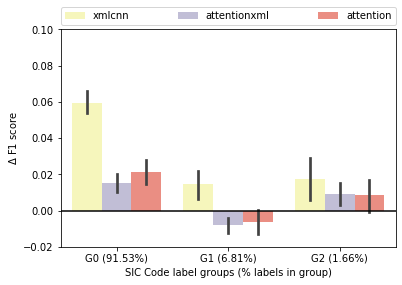

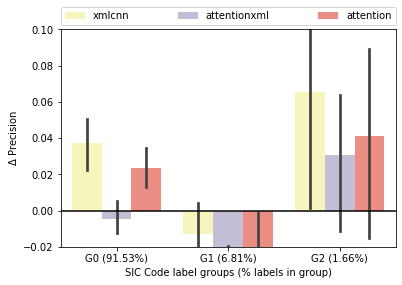

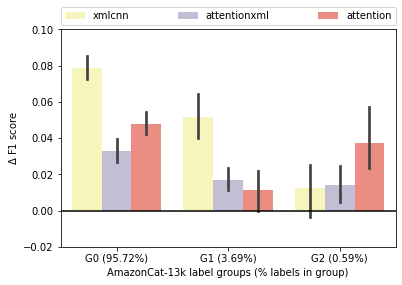

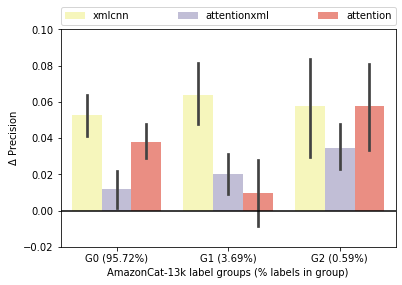

In [88]:
# change in model performance with changed loss (NOT A FAIR COMPARISON)
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['xmlcnn','attentionxml','attention']
metrics = ['F1','precision']

# function
df1 = df
df1 = df1[df1.model.isin(models)]
df1 = df1.set_index(['loss','per_hierarchy','input','model','lab_ind','group'])
df1 = df1.drop(columns=['dir'])
# calculation
df1 = (df1.loc[('categorical',True),:]-df1.loc[('binary',False),:]) # change in score
df1 = df1.reset_index(['group','model','lab_ind'])
# bar chart of mean
for data in datas:
    df2 = df1.loc[data,:]
    for metric in metrics:
        # y tick counts
        cnts = (df2.group.value_counts()/df2.group.value_counts().sum()*100).to_dict()
        groups = sorted(cnts.keys())
        # plot
        fig,ax = plt.subplots()
        bar = sns.barplot(
            x = 'group',
            y=metric,
            hue='model',
            data = df2,
            ax = ax, 
            palette=sns.color_palette("Set3")[1:],
            order=groups,
            hue_order = models
           )
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=len(models), mode="expand", borderaxespad=0.)
        ax.set_ylabel('$\Delta$ {}'.format(metric_dict[metric]))
        ax.set_xlabel('{} label groups (% labels in group)'.format(data_dict[data]))
        ax.set_xticklabels(['{} ({:.2f}%)'.format(key,cnts[key]) for key in groups])
        ax.axhline(y=0, color='k')
        ax.set_ylim(-0.02,0.1)
        plt.show()

### play

In [ ]:
# categorical loss model performance including bert
# PARAMS
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['FastText','xmlcnn','attentionxml','bert']
metrics = ['precision','F1']

# function
df1 = df
df1 = df1[df1.loss=='categorical']
df1 = df1[df1.model.isin(models)]
df1 = df1[df1.per_hierarchy == True]
# bar chart of mean
for data in datas:
    df2 = df1[df1.input==data]
    for metric in metrics:
        # y tick counts
        cnts = (df2.group.value_counts()/df2.group.value_counts().sum()*100).to_dict()
        groups = sorted(cnts.keys())
        # plot
        fig,ax = plt.subplots()
        bar = sns.barplot(
            x = 'group',
            y=metric,
            hue='model',
            data = df2,
            ax = ax, 
            palette="Set3",
            order=groups,
            hue_order = models
           )
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=len(models), mode="expand", borderaxespad=0.)
        ax.set_ylabel('{}'.format(metric_dict[metric]))
        ax.set_xlabel('{} label groups (% labels in group)'.format(data_dict[data]))
        ax.set_xticklabels(['{} ({:.2f}%)'.format(key,cnts[key]) for key in groups])
        plt.show()

In [ ]:
# change in model performance with changed loss
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['xmlcnn','attentionxml','attention']
metrics = ['F1','precision']

# function
df1 = df
df1 = df1[df1.model.isin(models)]
df1 = df1[df1.per_hierarchy == True].drop(columns=['per_hierarchy'])
df1 = df1.set_index(['loss']+[col for col in df1.columns if col not in metrics + ['loss']]).reset_index(['dir'])
df1 = df1.drop(columns=['dir'])
# calculation
df1 = (df1.loc['categorical',:]-df1.loc['binary',:]) # change in score
df1 = df1.reset_index(['group','model','lab_ind'])
# bar chart of mean
for data in datas:
    df2 = df1.loc[data,:]
    for metric in metrics:
        # y tick counts
        cnts = (df2.group.value_counts()/df2.group.value_counts().sum()*100).to_dict()
        groups = sorted(cnts.keys())
        # plot
        fig,ax = plt.subplots()
        bar = sns.barplot(
            x = 'group',
            y=metric,
            hue='model',
            data = df2,
            ax = ax, 
            palette=sns.color_palette("Set3")[1:],
            order=groups,
            hue_order = models
           )
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=len(models), mode="expand", borderaxespad=0.)
        ax.set_ylabel('$\Delta$ {}'.format(metric_dict[metric]))
        ax.set_xlabel('{} label groups (% labels in group)'.format(data_dict[data]))
        ax.set_xticklabels(['{} ({:.2f}%)'.format(key,cnts[key]) for key in groups])
        ax.axhline(y=0, color='k')
        ax.set_ylim(-0.025,0.08)
        plt.show()

In [ ]:
# change in model performance with changing calculation method
df1 = df
df1 = df1[df1.loss=='binary']
# df1 = df1[df1.model!='attention']
# df1 = df1[df1.model!='bert']
# df1 = df1[df1.model=='attentionxml']
df1  = df1.set_index(['loss','input','dir','model','group','lab_ind','per_hierarchy']).stack().unstack([-2,-1])
df1 = (df1.loc[:,(True)]-df1.loc[:,(False)]).reset_index()
df1 = df1[df1.input=='data/amazon_hierarchy_2']
# bar chart of mean
metrics = ['precision','F1']
y_labs = ['binary accuracy','F1 score']
for i in range(len(metrics)):
    metric = metrics[i]
    y_lab = y_labs[i]
    fig,ax = plt.subplots()
    sns.barplot(x = 'group',y=metric,hue='model',data = df1,ax = ax, palette="Set3",
                order=sorted(df1.group.unique()),
                hue_order = order
               )
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=len(df1.model.unique()), mode="expand", borderaxespad=0.)
    ax.set_ylabel(y_lab)
    ax.set_xlabel('AmazonCat-13k label groups')
    plt.show()

In [ ]:
df1 = df
df1 = df1[df1['per_hierarchy']==True].drop(columns=['per_hierarchy'])

# df1 = df1.drop(columns=['dir'])
# df1  = df1.set_index(['input','model','group','lab_ind','loss']).stack().unstack([-2,-1])
# df1


In [ ]:
df1 = df1.drop(columns=['dir'])

In [ ]:
df1.groupby(columns=['input','model','group','lab_ind','loss'])

In [ ]:
# change in model performance with changing calculation method
df1 = df
df1 = df1[df1.loss=='binary']
df1 = df1[df1['per_hierarchy']==True]
# df1 = df1[df1.model!='attention']
# df1 = df1[df1.model!='bert']
# df1 = df1[df1.model=='attentionxml']
df1  = df1.set_index(['input','dir','model','group','lab_ind','loss']).stack().unstack([-2,-1])
df1 = (df1.loc[:,('categorical')]-df1.loc[:,('binary')]).reset_index()
df1 = df1[df1.input=='data/amazon_hierarchy_2']
# bar chart of mean
metrics = ['precision','F1']
y_labs = ['binary accuracy','F1 score']
for i in range(len(metrics)):
    metric = metrics[i]
    y_lab = y_labs[i]
    fig,ax = plt.subplots()
    sns.barplot(x = 'group',y=metric,hue='model',data = df1,ax = ax, palette="Set3",
                order=sorted(df1.group.unique()),
                hue_order = order
               )
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=len(df1.model.unique()), mode="expand", borderaxespad=0.)
    ax.set_ylabel(y_lab)
    ax.set_xlabel('AmazonCat-13k label groups')
    plt.show()

# multi-lab metrics